In [1]:
import sys
sys.path.append('../src/')
from glob import glob
replays = glob('../data/sc2replays/*')

In [149]:
import numpy as np
import pandas as pd
from stringdist import levenshtein
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from matplotlib import cm
from IPython.core.display import display, HTML

In [2]:
from building import zerg_buildings, protoss_buildings, terran_buildings

In [3]:
from spawningtool import parser

In [18]:
bo = []
for filepath in replays[:1000]:
    try:
        replay = parser.parse_replay(filepath)
        if len(replay['players']) == 2:
            if replay['players'][1]['race'] == 'Terran':
                bo.append([b['name'] for b in replay['players'][1]['buildOrder'] if b['name'] in terran_buildings])
            elif replay['players'][2]['race'] == 'Terran':
                bo.append([b['name'] for b in replay['players'][2]['buildOrder'] if b['name'] in terran_buildings])
    except:
        print(filepath)
        pass

../data/sc2replays\00396d150ebfaa13f0072e841e4fc12b.SC2Replay
../data/sc2replays\02889e423747577fd557212e9ab038b2.SC2Replay
../data/sc2replays\03efe02cd003c31f37dab4d69dadec26.SC2Replay
../data/sc2replays\0493bd7f584cb6a44542ee3caf46154b.SC2Replay
../data/sc2replays\0976f8c9d7f3e92f446ed2f2e6792e4e.SC2Replay
../data/sc2replays\0eccf8feacc3b57111a3ed0effd62c48.SC2Replay
../data/sc2replays\0f91e2c1f2ff9705ef91568919cf0bb2.SC2Replay
../data/sc2replays\1762979921f1b77fcdd77eca03e89c8d.SC2Replay
../data/sc2replays\1886c2d75ac3db92340d0f0447893f26.SC2Replay


In [19]:
len(bo)

422

In [20]:
build_dict = {b: chr(i+97) for i,b in enumerate(sorted(terran_buildings))}

In [83]:
build_dict

{'Armory': 'a',
 'AutoTurret': 'b',
 'Barracks': 'c',
 'Bunker': 'd',
 'CommandCenter': 'e',
 'EngineeringBay': 'f',
 'Factory': 'g',
 'FusionCore': 'h',
 'GhostAcademy': 'i',
 'MissileTurret': 'j',
 'OrbitalCommand': 'k',
 'PlanetaryFortress': 'l',
 'Reactor': 'm',
 'Refinery': 'n',
 'SensorTower': 'o',
 'Starport': 'p',
 'SupplyDepot': 'q',
 'TechLab': 'r'}

In [21]:
bo_str = []
for b in bo:
    bo_str.append(''.join([build_dict[row] for row in b if row in terran_buildings]))

In [25]:
mat = np.zeros((len(bo_str), len(bo_str)))
for i,a in enumerate(bo_str):
    for j,b in enumerate(bo_str):
        mat[i,j] = levenshtein(a,b)

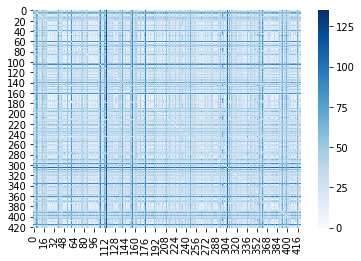

In [31]:
sns.heatmap(mat, cmap='Blues')
plt.show()

### Clustering

In [36]:
from sklearn.cluster import DBSCAN, AffinityPropagation
from sklearn.preprocessing import StandardScaler

In [41]:
from collections import Counter

In [32]:
X = StandardScaler().fit_transform(mat)
db = DBSCAN().fit(X)

In [207]:
ap = AffinityPropagation(affinity='precomputed', damping=0.9, max_iter=500).fit(X)

In [208]:
c = pd.DataFrame({'y':list(Counter(ap.labels_).values()), 'x':list(Counter(ap.labels_).keys())})

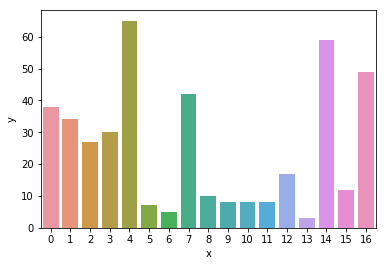

In [209]:
sns.barplot(x='x', y='y', data=c)
plt.show()

In [210]:
char_dict = {}
for i,c in enumerate(build_dict.values()):
    char_dict[c] = mcolors.to_hex(cm.tab20c.colors[i])

In [211]:
def format_chars(s, char_dict):
    letters = lambda x: "<span style='color:{};'>{}</span>".format(char_dict[x],x)
    text = "".join(list(map(letters, s)))
    text = "<div style='font-size:10pt;font-weight:normal;'>" + text + "</div>"
    display(HTML(text))

In [215]:
for i in np.where(ap.labels_ == 1)[0]:
    format_chars(bo_str[i], char_dict)

In [213]:
ord_mat = np.array([mat[np.argsort(ap.labels_),x] for x in np.argsort(ap.labels_)])

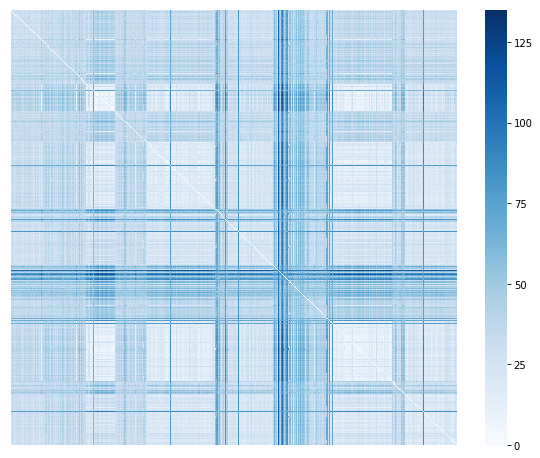

In [214]:
plt.figure(figsize=(10,8))
sns.heatmap(ord_mat, cmap='Blues', xticklabels=False, yticklabels=False)
plt.show()

### Clustering openings

In [252]:
bo_str = []
for b in bo:
    opening = b[:10]
    if len(opening) == 10:
        bo_str.append(''.join([build_dict[row] for row in opening if row in terran_buildings]))

In [253]:
bo_str[:3]

['qcnkecqcfk', 'qenckgkenq', 'qncgkqnepg']

In [254]:
mat = np.zeros((len(bo_str), len(bo_str)))
for i,a in enumerate(bo_str):
    for j,b in enumerate(bo_str):
        mat[i,j] = levenshtein(a,b)

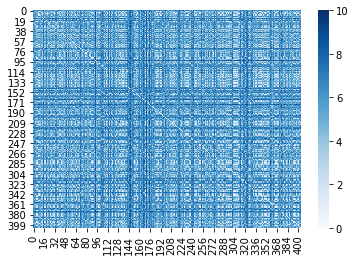

In [255]:
sns.heatmap(mat, cmap='Blues')
plt.show()

In [220]:
X = StandardScaler().fit_transform(mat)
db = DBSCAN().fit(X)

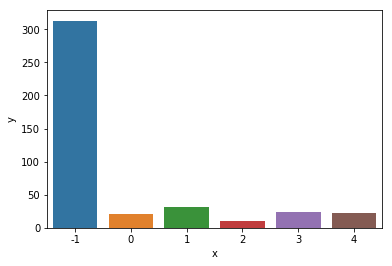

In [224]:
c = pd.DataFrame({'y':list(Counter(db.labels_).values()), 'x':list(Counter(db.labels_).keys())})
sns.barplot(x='x', y='y', data=c)
plt.show()

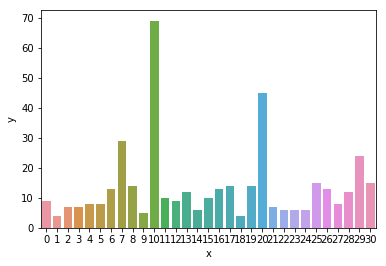

In [225]:
ap = AffinityPropagation(affinity='precomputed', damping=0.9, max_iter=500).fit(X)
c = pd.DataFrame({'y':list(Counter(ap.labels_).values()), 'x':list(Counter(ap.labels_).keys())})
sns.barplot(x='x', y='y', data=c)
plt.show()

### Frequencies

In [256]:
bo_str[:3]

['qcnkecqcfk', 'qenckgkenq', 'qncgkqnepg']

In [257]:
def query_build(build, position, bo_str):
    return np.sum([b[int(position)] == str(build) for b in bo_str])/float(len(bo_str))

In [258]:
np.sum([b[9] == 'q' for b in bo_str[:3]])/float(len(bo_str[:3]))

0.3333333333333333

In [259]:
mat = np.zeros((10, len(build_dict.values())))

In [260]:
for i in range(10):
    for j,build in enumerate(build_dict.values()):
        mat[i,j] = query_build(build, i, bo_str)

In [262]:
df = pd.DataFrame(mat, columns=list(build_dict.keys()))

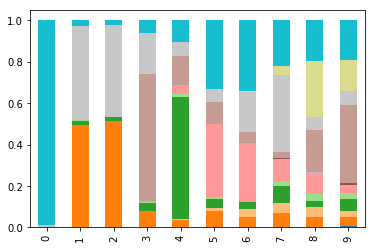

In [266]:
df.plot(kind='bar', stacked=True, colormap=cm.tab20, legend=False)
plt.show()

In [268]:
df.T

,0,1,2,3,4,5,6,7,8,9
Armory,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002469,0.002469,0.007407
AutoTurret,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Barracks,0.000000,0.493827,0.513580,0.081481,0.034568,0.081481,0.051852,0.069136,0.049383,0.041975
Bunker,0.000000,0.000000,0.000000,0.000000,0.004938,0.012346,0.039506,0.044444,0.044444,0.032099
CommandCenter,0.000000,0.022222,0.017284,0.034568,0.592593,0.044444,0.029630,0.083951,0.029630,0.056790
EngineeringBay,0.000000,0.004938,0.002469,0.007407,0.009877,0.007407,0.002469,0.022222,0.034568,0.027160
Factory,0.000000,0.000000,0.000000,0.004938,0.046914,0.353086,0.283951,0.101235,0.098765,0.039506
FusionCore,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
GhostAcademy,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004938,0.007407,0.000000
MissileTurret,0.000000,0.000000,0.000000,0.000000,0.000000,0.002469,0.000000,0.004938,0.000000,0.009877


### Select BO and plot timings
SupplyDepot > Barracks > Refinery > OrbitalCommand > CommandCenter > SupplyDepot > Factory > Refinery > Starport > OrbitalCommand


In [269]:
build_dict

{'Armory': 'a',
 'AutoTurret': 'b',
 'Barracks': 'c',
 'Bunker': 'd',
 'CommandCenter': 'e',
 'EngineeringBay': 'f',
 'Factory': 'g',
 'FusionCore': 'h',
 'GhostAcademy': 'i',
 'MissileTurret': 'j',
 'OrbitalCommand': 'k',
 'PlanetaryFortress': 'l',
 'Reactor': 'm',
 'Refinery': 'n',
 'SensorTower': 'o',
 'Starport': 'p',
 'SupplyDepot': 'q',
 'TechLab': 'r'}

In [312]:
BO_list = [
    'SupplyDepot' ,
    'Barracks' ,
    'Refinery' ,
    'OrbitalCommand' ,
    'CommandCenter' ,
    'Factory' ,
    'Starport' 
]

In [270]:
BO = 'qcnkeqgnpk'

In [271]:
sel_bo = [b for b in bo_str if b == BO]

In [272]:
len(sel_bo)

22

In [439]:
replay = parser.parse_replay(replays[0])
replay['players'][1]

{'name': 'Probe',
 'pick_race': 'Protoss',
 'race': 'Protoss',
 'league': 0,
 'level': 4294967295,
 'is_winner': True,
 'result': 'Win',
 'is_human': True,
 'handicap': 100,
 'color': 'B4141E',
 'uid': 10313865,
 'region': 'us',
 'supply': [[0, 12],
  [1, 12],
  [160, 13],
  [320, 14],
  [480, 14],
  [640, 15],
  [800, 15],
  [960, 16],
  [1120, 17],
  [1280, 18],
  [1440, 19],
  [1600, 19],
  [1760, 20],
  [1920, 19],
  [2080, 21],
  [2240, 21],
  [2400, 23],
  [2560, 23],
  [2720, 23],
  [2880, 24],
  [3040, 26],
  [3200, 27],
  [3360, 27],
  [3520, 28],
  [3680, 29],
  [3840, 29],
  [4000, 31],
  [4160, 31],
  [4320, 31],
  [4480, 27],
  [4640, 27],
  [4800, 29],
  [4960, 31],
  [5120, 31],
  [5280, 33],
  [5440, 35],
  [5600, 37],
  [5760, 37],
  [5920, 38],
  [6080, 40],
  [6094, 40]],
 'team': 1,
 'clock_position': None,
 'commander': '',
 'abilities': [],
 'buildOrder': [{'frame': 17.200000000000045,
   'time': '0:00',
   'name': 'Probe',
   'supply': 12,
   'is_worker': True,
 

In [441]:
win_bo_timings = []
loss_bo_timings = []

for filepath in replays[:1000]:
    try:
        replay = parser.parse_replay(filepath)
        if len(replay['players']) == 2:
            if replay['players'][1]['race'] == 'Terran':
                if replay['players'][1]['is_winner']:
                    win_bo_timings.append([(b['frame']/11.278,b['name']) for b in replay['players'][1]['buildOrder'] if b['name'] in terran_buildings])
                else:
                    loss_bo_timings.append([(b['frame']/11.278,b['name']) for b in replay['players'][1]['buildOrder'] if b['name'] in terran_buildings])
            elif replay['players'][2]['race'] == 'Terran':
                if replay['players'][2]['is_winner']:
                    win_bo_timings.append([(b['frame']/11.278,b['name']) for b in replay['players'][2]['buildOrder'] if b['name'] in terran_buildings])
                else:
                    loss_bo_timings.append([(b['frame']/11.278,b['name']) for b in replay['players'][2]['buildOrder'] if b['name'] in terran_buildings])
    except:
#         print(filepath)
        pass

In [442]:
from collections import defaultdict

In [443]:
win_timing_list = []
loss_timing_list = []
for t in win_bo_timings:
    win_timings = defaultdict(list)
    for build in BO_list:
        for row in t:
            if row[1] == build:
                win_timings[build].append(float(row[0]))
    win_timing_list.append(win_timings)
for t in loss_bo_timings:
    loss_timings = defaultdict(list)
    for build in BO_list:
        for row in t:
            if row[1] == build:
                loss_timings[build].append(float(row[0]))
    loss_timing_list.append(loss_timings)


In [444]:
win_general_timings = defaultdict(list)
loss_general_timings = defaultdict(list)

for t in win_timing_list:
    if t['SupplyDepot']:
        win_general_timings['firstSupplyDepot'].append(t['SupplyDepot'][0])
    if len(t['SupplyDepot']) > 1:
        win_general_timings['secondSupplyDepot'].append(t['SupplyDepot'][1])
    if t['Barracks']:
        win_general_timings['Barracks'].append(t['Barracks'][0])
    if t['Refinery']:
        win_general_timings['firstRefinery'].append(t['Refinery'][0])
    if len(t['Refinery']) > 1:
        win_general_timings['secondRefinery'].append(t['Refinery'][1])
    if t['OrbitalCommand']:
        win_general_timings['firstOrbitalCommand'].append(t['OrbitalCommand'][0])
    if len(t['OrbitalCommand']) > 1:
        win_general_timings['secondOrbitalCommand'].append(t['OrbitalCommand'][1])
    if t['CommandCenter']:
        win_general_timings['CommandCenter'].append(t['CommandCenter'][0])
    if t['Factory']:
        win_general_timings['Factory'].append(t['Factory'][0])
    if t['Starport']:
        win_general_timings['Starport'].append(t['Starport'][0])
for t in loss_timing_list:
    if t['SupplyDepot']:
        loss_general_timings['firstSupplyDepot'].append(t['SupplyDepot'][0])
    if len(t['SupplyDepot']) > 1:
        loss_general_timings['secondSupplyDepot'].append(t['SupplyDepot'][1])
    if t['Barracks']:
        loss_general_timings['Barracks'].append(t['Barracks'][0])
    if t['Refinery']:
        loss_general_timings['firstRefinery'].append(t['Refinery'][0])
    if len(t['Refinery']) > 1:
        loss_general_timings['secondRefinery'].append(t['Refinery'][1])
    if t['OrbitalCommand']:
        loss_general_timings['firstOrbitalCommand'].append(t['OrbitalCommand'][0])
    if len(t['OrbitalCommand']) > 1:
        loss_general_timings['secondOrbitalCommand'].append(t['OrbitalCommand'][1])
    if t['CommandCenter']:
        loss_general_timings['CommandCenter'].append(t['CommandCenter'][0])
    if t['Factory']:
        loss_general_timings['Factory'].append(t['Factory'][0])
    if t['Starport']:
        loss_general_timings['Starport'].append(t['Starport'][0])

In [445]:
def append_df(general_timings, label, win):
    return pd.DataFrame({'values':general_timings[label],'build': [label]*len(general_timings[label]), 'win':[win]*len(general_timings[label])})
    

In [446]:
df = pd.DataFrame({'build':[], 'values':[], 'win':[]})
for label in ['firstSupplyDepot','Barracks', 'firstRefinery', 'firstOrbitalCommand', 'CommandCenter', 'secondSupplyDepot', 'Factory', 'firstRefinery', 'Starport', 'secondOrbitalCommand']:
    x = append_df(win_general_timings, label, True)
    y = append_df(loss_general_timings, label, False)
    df = pd.concat([df, x, y], sort=False, ignore_index=True)

In [447]:
sns.set_style("whitegrid", {"xtick.major.size": 8,"xtick.minor.style":5, "ytick.major.size": 8})

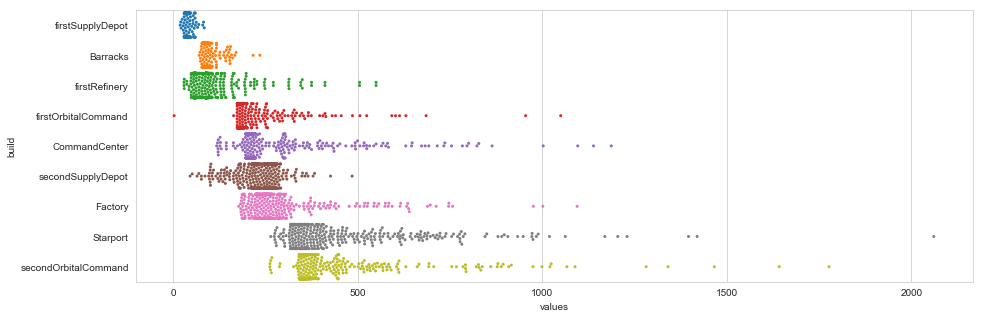

In [448]:
plt.figure(figsize=(15,5))
sns.swarmplot(x='values', y='build', data=df, size=3)
plt.show()

<Figure size 1080x360 with 0 Axes>

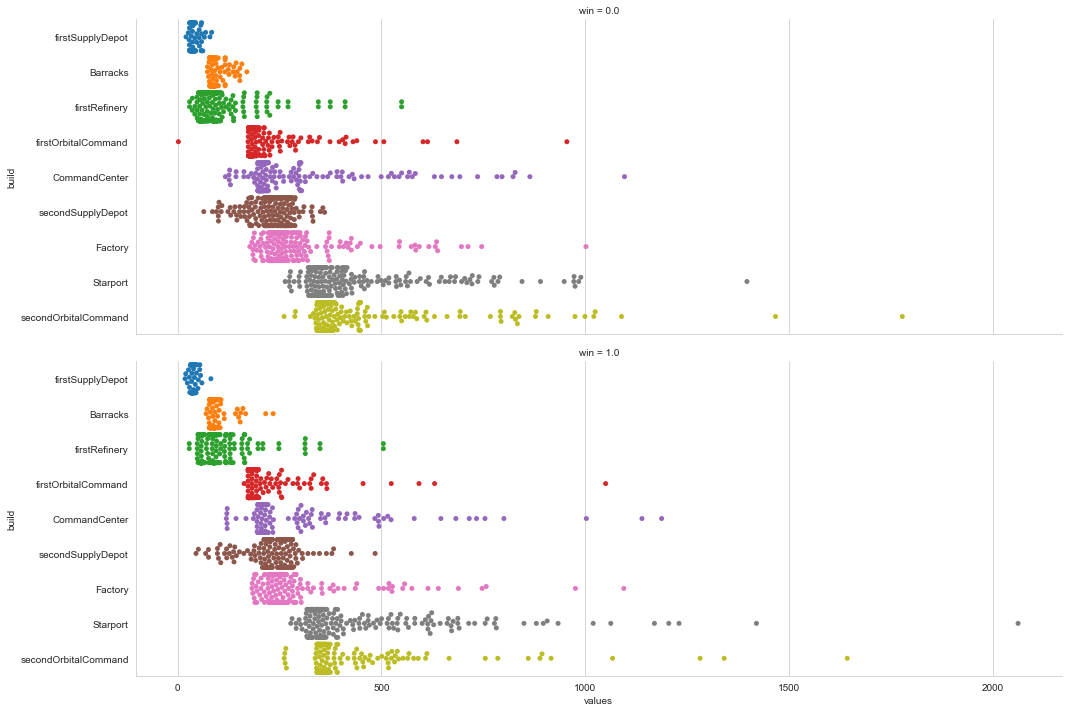

In [449]:
plt.figure(figsize=(15,5))
sns.catplot(x="values", y="build",row="win",data=df, kind="swarm", height=5, aspect=3)
plt.show()